In [1]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


TASK 4 a) Using Gradient Descent

--- Reconstructing 30x30 Block (Rank=40) ---
Iteration 100, RMSE: 24.3898
Iteration 200, RMSE: 17.0710
Iteration 300, RMSE: 13.2017
Iteration 400, RMSE: 10.7739
Iteration 500, RMSE: 9.3211
Iteration 600, RMSE: 8.4620
Iteration 700, RMSE: 7.8213
Iteration 800, RMSE: 7.4144
Iteration 900, RMSE: 7.2384
Iteration 1000, RMSE: 7.1770
Iteration 1100, RMSE: 7.1445
Iteration 1200, RMSE: 7.1199
Iteration 1300, RMSE: 7.0998
Iteration 1400, RMSE: 7.0831
Iteration 1500, RMSE: 7.0689
Iteration 1600, RMSE: 7.0568

Converged at iteration 1674, RMSE change < 0.0001

Metrics for Block Reconstruction:
RMSE: 11.1925
Peak SNR: 27.1522 dB

--- Reconstructing 900 Random Pixels (Rank=40) ---
Iteration 100, RMSE: 24.5952
Iteration 200, RMSE: 17.0772
Iteration 300, RMSE: 13.2620
Iteration 400, RMSE: 10.6083
Iteration 500, RMSE: 9.2460
Iteration 600, RMSE: 8.4023
Iteration 700, RMSE: 7.7715
Iteration 800, RMSE: 7.3829
Iteration 900, RMSE: 7.2124
Iteration 1000, RMSE: 7.1609
Iteration 1100, RMSE: 7.1433

Converge

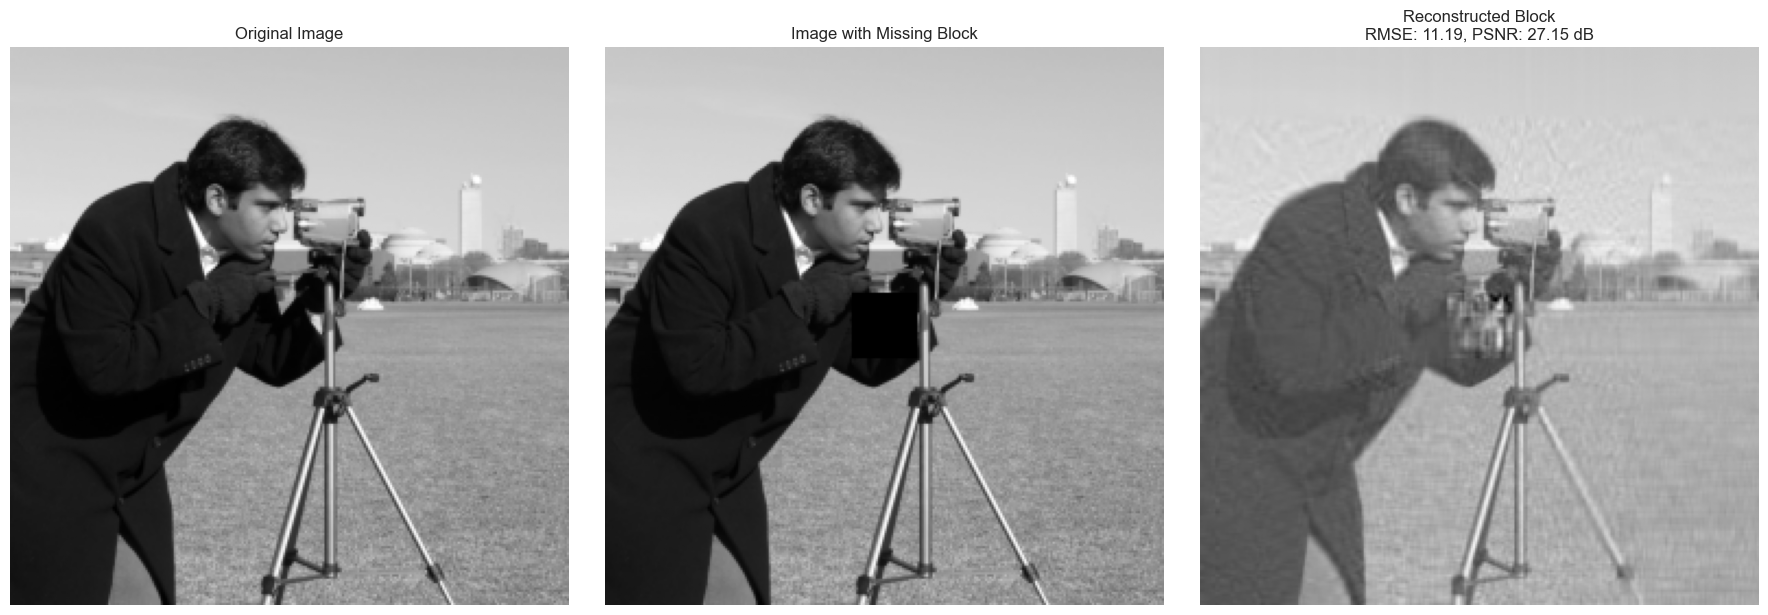

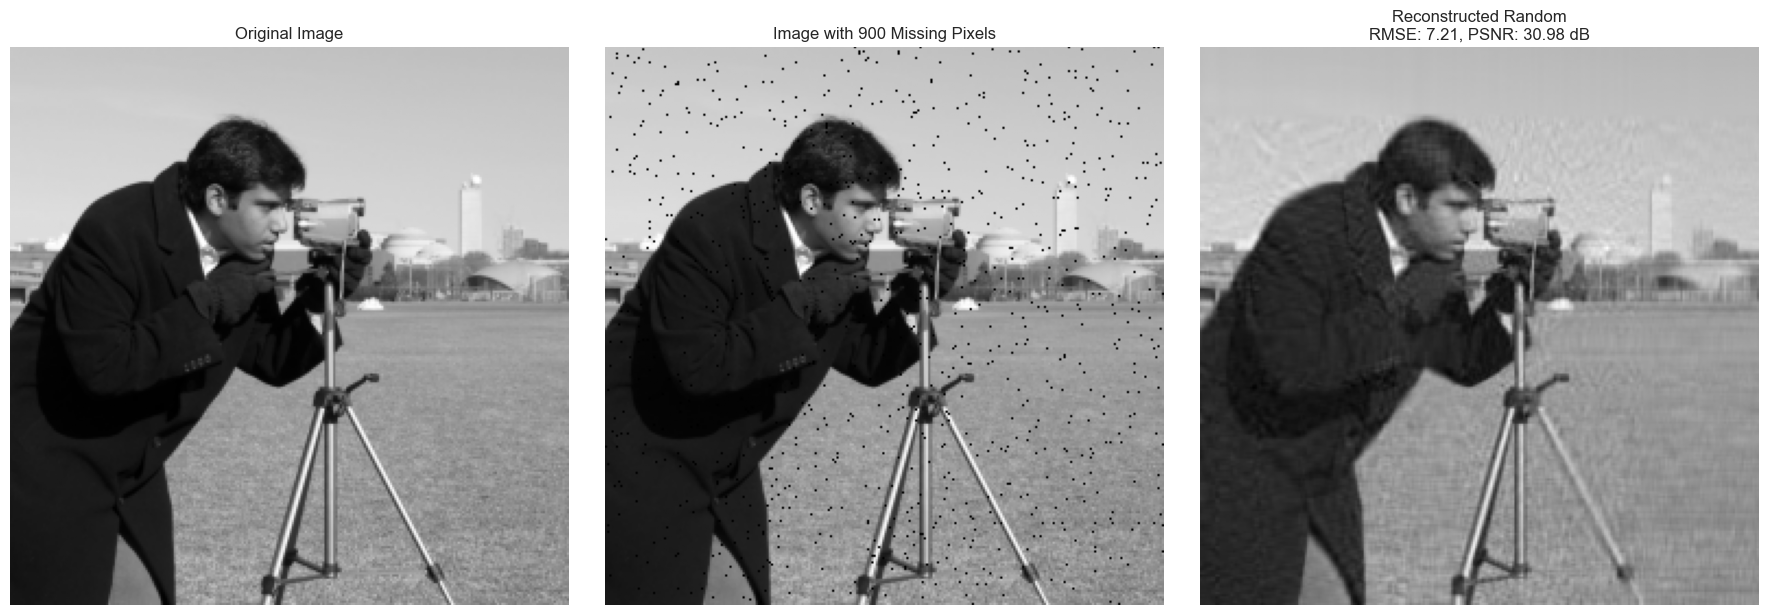

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.data import camera
from skimage import transform


def rmse(true, pred):
    """Calculates the Root Mean Squared Error."""
    return np.sqrt(np.mean((true - pred) ** 2))

def psnr(true, pred, max_val=255):
    """Calculates the Peak Signal-to-Noise Ratio."""
    mse = np.mean((true - pred) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(max_val) - 10 * np.log10(mse)

def matrix_factorization_gd(M, mask, rank, lr=0.0001, lambda_reg=0.01, iterations=1000, verbose=True):
    """
    Performs Matrix Factorization using Gradient Descent.
    """
    n, m = M.shape
    
    # Initialize factor matrices P and Q with small random values
    P = np.random.rand(n, rank) * 0.1
    Q = np.random.rand(m, rank) * 0.1
    
    prev_rmse = float('inf')
    tolerance = 1e-4 # convergence threshold

    for i in range(iterations):
        M_pred = P @ Q.T
        error = M - M_pred
        masked_error = error * mask
        
        grad_P = -2 * (masked_error @ Q) + 2 * lambda_reg * P
        grad_Q = -2 * (masked_error.T @ P) + 2 * lambda_reg * Q
        
        P -= lr * grad_P
        Q -= lr * grad_Q
        
        # Compute RMSE on known pixels
        current_rmse = rmse(M[mask], M_pred[mask])
        
        if verbose and (i + 1) % 100 == 0:
            print(f"Iteration {i+1}, RMSE: {current_rmse:.4f}")
        
        # Check convergence
        if abs(prev_rmse - current_rmse) < tolerance:
            print(f"\nConverged at iteration {i+1}, RMSE change < {tolerance}")
            break
        
        prev_rmse = current_rmse

            
    return P @ Q.T

# --- Image Preparation ---
# Load and preprocess the image
original_image = camera()
# Resize for faster computation
original_image = transform.resize(original_image, (256, 256), anti_aliasing=True) * 255
n1, n2 = original_image.shape

# Normalize the image by subtracting the mean for better convergence
mean_pixel = original_image.mean()
image_norm = original_image - mean_pixel

# --- 2. Case A: Reconstructing a Missing Rectangular Block ---
start_row, start_col = n1 // 2 - 15, n2 // 2 - 15
end_row, end_col = n1 // 2 + 15, n2 // 2 + 15

mask_block = np.ones((n1, n2), dtype=bool)
mask_block[start_row:end_row, start_col:end_col] = False

image_missing_block = image_norm.copy()
image_missing_block[~mask_block] = 0

rank_r = 40
print(f"--- Reconstructing 30x30 Block (Rank={rank_r}) ---")
reconstructed_image_block_norm = matrix_factorization_gd(
    image_missing_block, 
    mask_block, 
    rank=rank_r, 
    iterations=5000,
    lr=0.00001 
)

reconstructed_image_block = reconstructed_image_block_norm + mean_pixel
rmse_block = rmse(original_image, reconstructed_image_block)
psnr_block = psnr(original_image, reconstructed_image_block)

print(f"\nMetrics for Block Reconstruction:")
print(f"RMSE: {rmse_block:.4f}")
print(f"Peak SNR: {psnr_block:.4f} dB\n")


# --- 3. Case B: Reconstructing Randomly Missing Pixels ---
num_missing_pixels = 30 * 30
np.random.seed(42)
random_indices = np.random.choice(n1 * n2, num_missing_pixels, replace=False)
row_indices, col_indices = np.unravel_index(random_indices, (n1, n2))

mask_random = np.ones((n1, n2), dtype=bool)
mask_random[row_indices, col_indices] = False

image_missing_random = image_norm.copy()
image_missing_random[~mask_random] = 0

print(f"--- Reconstructing 900 Random Pixels (Rank={rank_r}) ---")
reconstructed_image_random_norm = matrix_factorization_gd(
    image_missing_random, 
    mask_random, 
    rank=rank_r,
    iterations=5000,
    lr=0.00001 
)

reconstructed_image_random = reconstructed_image_random_norm + mean_pixel
rmse_random = rmse(original_image, reconstructed_image_random)
psnr_random = psnr(original_image, reconstructed_image_random)

print(f"\nMetrics for Random Pixel Reconstruction:")
print(f"RMSE: {rmse_random:.4f}")
print(f"Peak SNR: {psnr_random:.4f} dB")


# --- 4. Plotting Results ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
image_with_missing_block_display = original_image.copy().astype(float)
image_with_missing_block_display[~mask_block] = 0
axes[1].imshow(image_with_missing_block_display, cmap='gray')
axes[1].set_title('Image with Missing Block')
axes[1].axis('off')
axes[2].imshow(reconstructed_image_block, cmap='gray')
axes[2].set_title(f'Reconstructed Block\nRMSE: {rmse_block:.2f}, PSNR: {psnr_block:.2f} dB')
axes[2].axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
image_with_missing_random_display = original_image.copy().astype(float)
image_with_missing_random_display[~mask_random] = 0
axes[1].imshow(image_with_missing_random_display, cmap='gray')
axes[1].set_title('Image with 900 Missing Pixels')
axes[1].axis('off')
axes[2].imshow(reconstructed_image_random, cmap='gray')
axes[2].set_title(f'Reconstructed Random\nRMSE: {rmse_random:.2f}, PSNR: {psnr_random:.2f} dB')
axes[2].axis('off')
plt.tight_layout()
plt.show()

Using ALS (Alternating Least Squares)

--- Reconstructing 30x30 Block with ALS (Rank=40) ---
Iteration 10/5000, Training RMSE: 7.558033
Iteration 20/5000, Training RMSE: 7.330420
Iteration 30/5000, Training RMSE: 7.283726
Iteration 40/5000, Training RMSE: 7.267179
Iteration 50/5000, Training RMSE: 7.259683
Iteration 60/5000, Training RMSE: 7.255913
Iteration 70/5000, Training RMSE: 7.253918

Converged at iteration 77, RMSE change < 0.0001

Metrics for Block Reconstruction (ALS):
RMSE: 11.7276
Peak SNR: 26.7466 dB


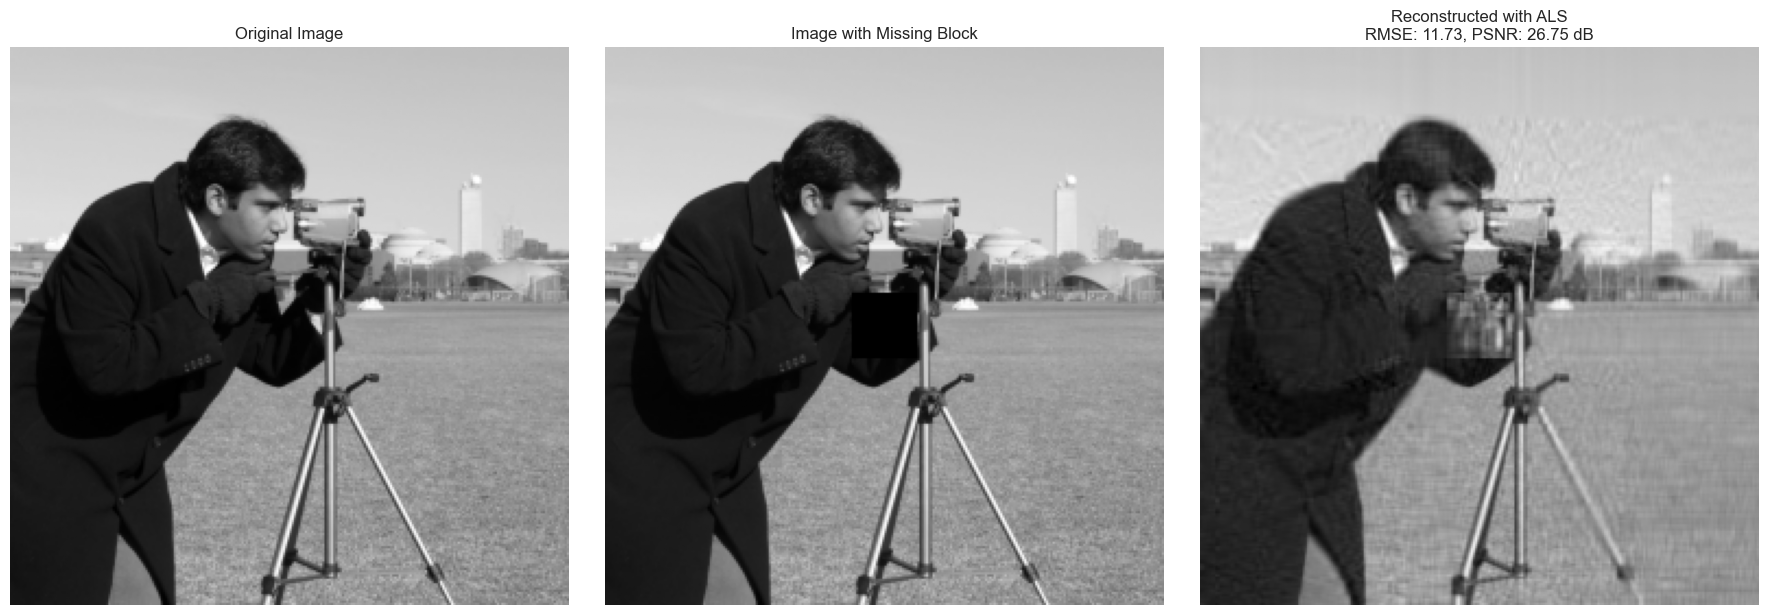


--- Reconstructing 900 Random Pixels with ALS (Rank=40) ---
Iteration 10/5000, Training RMSE: 7.616999
Iteration 20/5000, Training RMSE: 7.405674
Iteration 30/5000, Training RMSE: 7.352554
Iteration 40/5000, Training RMSE: 7.332213
Iteration 50/5000, Training RMSE: 7.324003
Iteration 60/5000, Training RMSE: 7.320189
Iteration 70/5000, Training RMSE: 7.318221

Converged at iteration 77, RMSE change < 0.0001

Metrics for Random Pixel Reconstruction (ALS):
RMSE: 7.3715
Peak SNR: 30.7797 dB


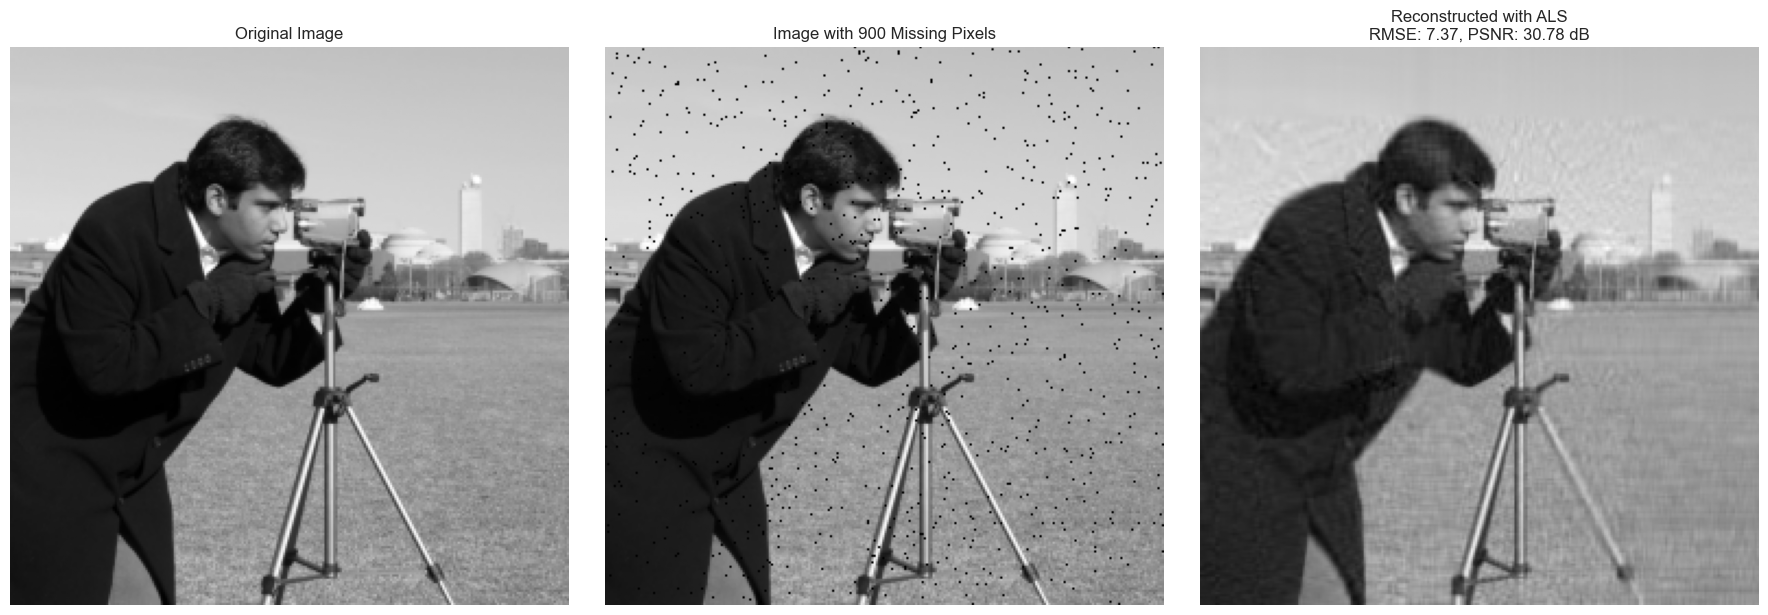

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import camera
from skimage import transform
import torch

def rmse(true, pred):
    """Calculates the Root Mean Squared Error."""
    return np.sqrt(np.mean((true - pred) ** 2))

def psnr(true, pred, max_val=255):
    """Calculates the Peak Signal-to-Noise Ratio."""
    mse = np.mean((true - pred) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(max_val) - 10 * np.log10(mse)

def matrix_factorization_als(M, mask, rank, lambda_reg=70, iterations=5000, 
                             tolerance=1e-4, verbose=True):
    """
    Performs Matrix Factorization using Alternating Least Squares (ALS) 
    """
    
    # Convert numpy arrays to torch tensors
    M_torch = torch.from_numpy(M).float()
    mask_torch = torch.from_numpy(mask)
    n, m = M_torch.shape

    # Initialize factor matrices
    Q = torch.rand(m, rank) * 0.1
    P = torch.zeros(n, rank)
    
    # Regularization matrix
    lambda_eye = torch.eye(rank) * np.sqrt(lambda_reg)
    
    prev_rmse = float('inf')
    
    for i in range(iterations):
        # --- Solve for P (given Q) ---
        for j in range(n):
            known_indices = mask_torch[j, :]
            if torch.sum(known_indices) > 0:
                Q_known = Q[known_indices, :]
                m_j_known = M_torch[j, known_indices]
                A = torch.cat([Q_known, lambda_eye])
                b = torch.cat([m_j_known, torch.zeros(rank)])
                P[j, :] = torch.linalg.lstsq(A, b).solution

        # --- Solve for Q (given P) ---
        for k in range(m):
            known_indices = mask_torch[:, k]
            if torch.sum(known_indices) > 0:
                P_known = P[known_indices, :]
                m_k_known = M_torch[known_indices, k]
                A = torch.cat([P_known, lambda_eye])
                b = torch.cat([m_k_known, torch.zeros(rank)])
                Q[k, :] = torch.linalg.lstsq(A, b).solution

        # Compute RMSE on known pixels
        M_pred = P @ Q.T
        current_rmse = np.sqrt(np.mean((M_torch[mask_torch].numpy() - M_pred[mask_torch].numpy())**2))
        
        # Print every 100 iterations
        if verbose and (i+1) % 10 == 0:
            print(f"Iteration {i+1}/{iterations}, Training RMSE: {current_rmse:.6f}")
        
        # Check convergence
        if abs(prev_rmse - current_rmse) < tolerance:
            print(f"\nConverged at iteration {i+1}, RMSE change < {tolerance}")
            break
        
        prev_rmse = current_rmse
    
    # Return reconstructed matrix as numpy array
    return (P @ Q.T).numpy()


# --- Image Preparation ---
original_image = camera()
original_image = transform.resize(original_image, (256, 256), anti_aliasing=True) * 255
n1, n2 = original_image.shape
mean_pixel = original_image.mean()
image_norm = original_image - mean_pixel

# --- Case A: Reconstructing a Missing Rectangular Block with ALS ---
start_row, start_col = n1 // 2 - 15, n2 // 2 - 15
end_row, end_col = n1 // 2 + 15, n2 // 2 + 15
mask_block = np.ones((n1, n2), dtype=bool)
mask_block[start_row:end_row, start_col:end_col] = False
image_missing_block = image_norm.copy()
image_missing_block[~mask_block] = 0

rank_r = 40
print(f"--- Reconstructing 30x30 Block with ALS (Rank={rank_r}) ---")
reconstructed_image_block_norm = matrix_factorization_als(
    image_missing_block, 
    mask_block, 
    rank=rank_r,
    iterations=5000, 
    tolerance=1e-4
)

reconstructed_image_block = reconstructed_image_block_norm + mean_pixel
rmse_block = rmse(original_image, reconstructed_image_block)
psnr_block = psnr(original_image, reconstructed_image_block)

print(f"\nMetrics for Block Reconstruction (ALS):")
print(f"RMSE: {rmse_block:.4f}")
print(f"Peak SNR: {psnr_block:.4f} dB")

# --- Plotting Results for Case A ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
image_with_missing_block_display = original_image.copy().astype(float)
image_with_missing_block_display[~mask_block] = 0
axes[1].imshow(image_with_missing_block_display, cmap='gray')
axes[1].set_title('Image with Missing Block')
axes[1].axis('off')
axes[2].imshow(reconstructed_image_block, cmap='gray')
axes[2].set_title(f'Reconstructed with ALS\nRMSE: {rmse_block:.2f}, PSNR: {psnr_block:.2f} dB')
axes[2].axis('off')
plt.tight_layout()
plt.show()

# --- Case B: Reconstructing Randomly Missing Pixels with ALS ---
num_missing_pixels = 30 * 30
np.random.seed(42)
random_indices = np.random.choice(n1 * n2, num_missing_pixels, replace=False)
row_indices, col_indices = np.unravel_index(random_indices, (n1, n2))
mask_random = np.ones((n1, n2), dtype=bool)
mask_random[row_indices, col_indices] = False
image_missing_random = image_norm.copy()
image_missing_random[~mask_random] = 0

print(f"\n--- Reconstructing 900 Random Pixels with ALS (Rank={rank_r}) ---")
reconstructed_image_random_norm = matrix_factorization_als(
    image_missing_random, 
    mask_random, 
    rank=rank_r,
    iterations=5000,
    tolerance=1e-4
)

reconstructed_image_random = reconstructed_image_random_norm + mean_pixel
rmse_random = rmse(original_image, reconstructed_image_random)
psnr_random = psnr(original_image, reconstructed_image_random)

print(f"\nMetrics for Random Pixel Reconstruction (ALS):")
print(f"RMSE: {rmse_random:.4f}")
print(f"Peak SNR: {psnr_random:.4f} dB")

# --- Plotting Results for Case B ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
image_with_missing_random_display = original_image.copy().astype(float)
image_with_missing_random_display[~mask_random] = 0
axes[1].imshow(image_with_missing_random_display, cmap='gray')
axes[1].set_title('Image with 900 Missing Pixels')
axes[1].axis('off')
axes[2].imshow(reconstructed_image_random, cmap='gray')
axes[2].set_title(f'Reconstructed with ALS\nRMSE: {rmse_random:.2f}, PSNR: {psnr_random:.2f} dB')
axes[2].axis('off')
plt.tight_layout()
plt.show()

TASK 4 b)

Processing patch 'A: Simple (Background)' with rank r=5...
Processing patch 'A: Simple (Background)' with rank r=10...
Processing patch 'A: Simple (Background)' with rank r=25...
Processing patch 'A: Simple (Background)' with rank r=50...
Processing patch 'C: Complex' with rank r=5...
Processing patch 'C: Complex' with rank r=10...
Processing patch 'C: Complex' with rank r=25...
Processing patch 'C: Complex' with rank r=50...
Processing patch 'B: Medium' with rank r=5...
Processing patch 'B: Medium' with rank r=10...
Processing patch 'B: Medium' with rank r=25...
Processing patch 'B: Medium' with rank r=50...


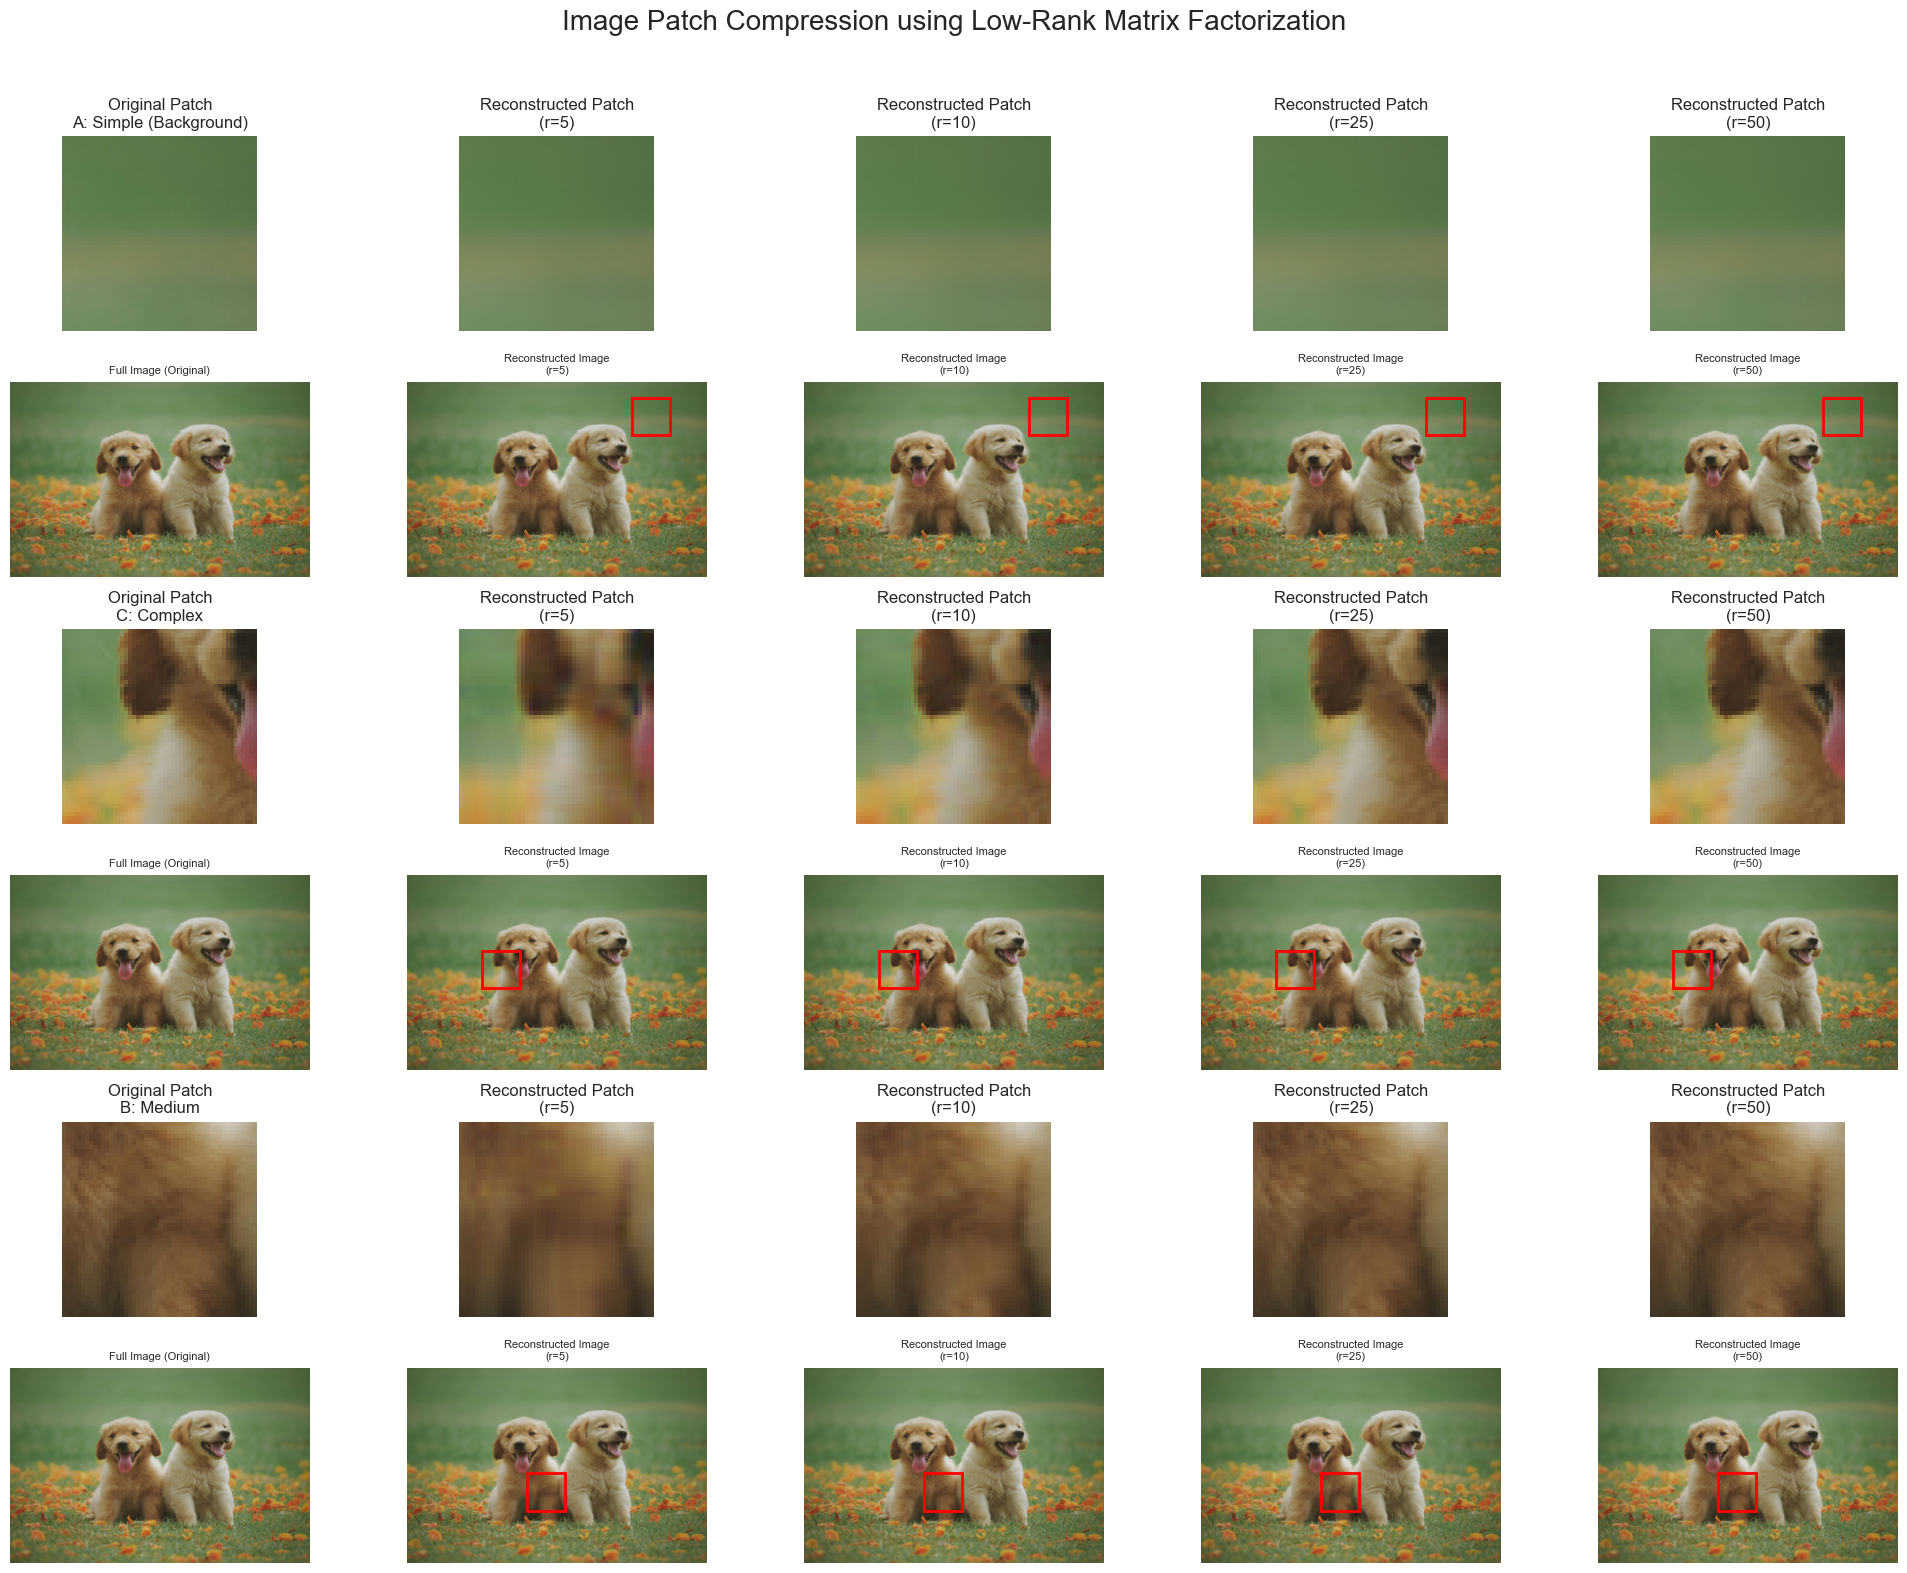

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import matplotlib.patches as mpl_patches


def matrix_factorization_gd(M, mask, rank, lr=0.0001, lambda_reg=0.01, iterations=1500, tolerance=1e-4, verbose=False):
    """
    Performs Matrix Factorization using Gradient Descent with convergence check.
    """
    n, m = M.shape
    P = np.random.rand(n, rank) * 0.1
    Q = np.random.rand(m, rank) * 0.1

    prev_rmse = float('inf')
    
    for i in range(iterations):
        M_pred = P @ Q.T
        error = M - M_pred
        masked_error = error * mask

        grad_P = -2 * (masked_error @ Q) + 2 * lambda_reg * P
        grad_Q = -2 * (masked_error.T @ P) + 2 * lambda_reg * Q

        P -= lr * grad_P
        Q -= lr * grad_Q

        # Convergence check
        current_rmse = np.sqrt(np.mean((masked_error)**2))
        if verbose and (i + 1) % 100 == 0:
            print(f"Iteration {i+1}, RMSE on known pixels: {current_rmse:.6f}")
        if abs(prev_rmse - current_rmse) < tolerance:
            if verbose:
                print(f"Converged at iteration {i+1}, RMSE change < {tolerance}")
            break
        prev_rmse = current_rmse

    return P @ Q.T


def compress_reconstruct_patch(patch, rank):
    """
    Compresses and reconstructs a color image patch channel by channel.
    """
    reconstructed_patch = np.zeros_like(patch, dtype=float)
    full_mask = np.ones((50, 50), dtype=bool)

    for channel in range(3):
        channel_data = patch[:, :, channel]
        mean_pixel = channel_data.mean()
        channel_norm = channel_data - mean_pixel
        
        reconstructed_norm = matrix_factorization_gd(
            channel_norm, 
            full_mask, 
            rank=rank,
            lr=0.0001,
            iterations=1500
        )
        
        reconstructed_patch[:, :, channel] = reconstructed_norm + mean_pixel
        
    return np.clip(reconstructed_patch, 0, 255).astype(np.uint8)

# --- Image Preparation ---
url = 'https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg'
response = requests.get(url)
original_image = np.array(Image.open(BytesIO(response.content)).resize((400,260)))

# Define patch locations based on the new image
patches = {
    "A: Simple (Background)": (slice(20, 70), slice(300, 350)),
    "C: Complex": (slice(100, 150), slice(100, 150)),
    "B: Medium": (slice(140, 190), slice(160, 210)),
}
ranks = [5, 10, 25, 50]

# --- Create a grid for plotting all reconstructions ---
# We'll have 3 major rows (for each patch case).
# Each major row will contain: Original Patch, then 4 columns of (Reconstructed Patch + Reconstructed Image)
# So, it's 3 * 2 rows and 5 columns
fig, axes = plt.subplots(len(patches) * 2, len(ranks) + 1, figsize=(20, 16))
fig.suptitle('Image Patch Compression using Low-Rank Matrix Factorization', fontsize=20)

for i, (title, patch_coords) in enumerate(patches.items()):
    # Extract the original patch
    original_patch = original_image[patch_coords]
    
    # --- Row 1 for this patch case: Original Patch & Reconstructed Patches ---
    # Display the original patch in the first column of the first sub-row
    axes[i*2, 0].imshow(original_patch)
    axes[i*2, 0].set_title(f"Original Patch\n{title}")
    axes[i*2, 0].axis('off')
    
    # --- Row 2 for this patch case: Reconstructed Images with Patch ---
    # Set the title for the empty cell in the first column of the second sub-row
    axes[i*2 + 1, 0].set_title(f"Full Image (Original)", fontsize=8)
    axes[i*2 + 1, 0].imshow(original_image)
    axes[i*2 + 1, 0].axis('off')

    # Loop through the different rank values
    for j, r in enumerate(ranks):
        print(f"Processing patch '{title}' with rank r={r}...")
        
        # Compress and reconstruct the patch
        reconstructed_patch = compress_reconstruct_patch(original_patch.copy(), rank=r)
        
        # --- Plot the Reconstructed Patch ---
        axes[i*2, j + 1].imshow(reconstructed_patch)
        axes[i*2, j + 1].set_title(f"Reconstructed Patch\n(r={r})")
        axes[i*2, j + 1].axis('off')
        
        # --- Plot the Full Image with Reconstructed Patch ---
        display_image = original_image.copy()
        display_image[patch_coords] = reconstructed_patch
        
        ax = axes[i*2 + 1, j + 1]
        ax.imshow(display_image)
        ax.set_title(f"Reconstructed Image\n(r={r})", fontsize=8)
        
        # Add a red rectangle to clearly show the patch location in the full image
        rect = mpl_patches.Rectangle(
            (patch_coords[1].start, patch_coords[0].start), 
            50, 50, 
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Observation 1: The Effect of Rank on Reconstruction Quality

The primary observation is the direct relationship between the rank (r) and the visual quality of the reconstructed patch.

Low Rank (r=5): This represents a very high level of compression. The reconstruction is blurry, blocky, and loses almost all fine details. It only captures the most general color and brightness information of the patch.

Medium Ranks (r=10,r=25): As the rank increases, the reconstruction quality improves dramatically. Details begin to emerge, edges become sharper, and the image is much more recognizable.

High Rank (r=50): This represents the lowest level of compression. For a 50x50 patch, a rank of 50 allows for a near-perfect reconstruction, as the number of parameters in the factor matrices is sufficient to capture all the information in the original patch. The reconstructed patch is visually almost identical to the original.

## Observation 2: The Impact of Image Complexity

The effectiveness of a given rank is highly dependent on the complexity of the image patch being compressed.

Patch A (Simple Background): This patch has low complexity (low spatial frequency). Even at a very low rank like r=5, the reconstruction is reasonably good because there are no sharp details to preserve. The difference in quality between r=25 and r=50 is minimal, suggesting that a low rank is sufficient to represent this simple area.

Patch B (Medium Complexity): For patch B, a rank of r=5 is poor, creating a blurry mess. However, at r=10 and r=25, the key features (like the nose, whiskers, and mouth line) become clearly visible. This shows that a moderate rank is needed to capture a moderate level of detail.

Patch C (High Complexity): Patch C is a high-complexity patch with fine fur texture, sharp edges, and reflections. At low ranks (r=5,r=10), the reconstruction completely fails to capture these details. A high rank (r=25 and especially r=50) is necessary to produce a visually faithful reconstruction of this complex area. The quality improvement with each step up in rank is most pronounced for this patch.